In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('./Google_Stock_Price_Train.csv')
test_data = pd.read_csv('./Google_Stock_Price_Test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [5]:
def isnum(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

In [6]:
data.loc[data['Close'].apply(lambda x: isnum(x))==False, 'Close']

451    1,008.64
452    1,000.55
453    1,004.24
454    1,028.59
455    1,022.74
         ...   
555    1,193.88
556    1,179.80
557    1,154.76
558    1,155.55
559    1,128.87
Name: Close, Length: 109, dtype: object

In [7]:
data['Close'] = data['Close'].str.replace(',', '', regex=False)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

In [8]:
data.loc[data['Volume'].apply(lambda x: isnum(x))==False, 'Volume']

0        7,380,500
1        5,749,400
2        6,590,300
3        5,405,900
4       11,688,800
           ...    
1253       623,400
1254       789,100
1255     1,153,800
1256       744,300
1257     1,770,000
Name: Volume, Length: 1258, dtype: object

In [9]:
data['Volume'] = data['Volume'].str.replace(',', '', regex=False)
data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

In [10]:
test_data['Volume'] = test_data['Volume'].str.replace(',', '', regex=False)
test_data['Volume'] = pd.to_numeric(test_data['Volume'], errors='coerce')

In [11]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m/%d/%Y', errors='coerce')

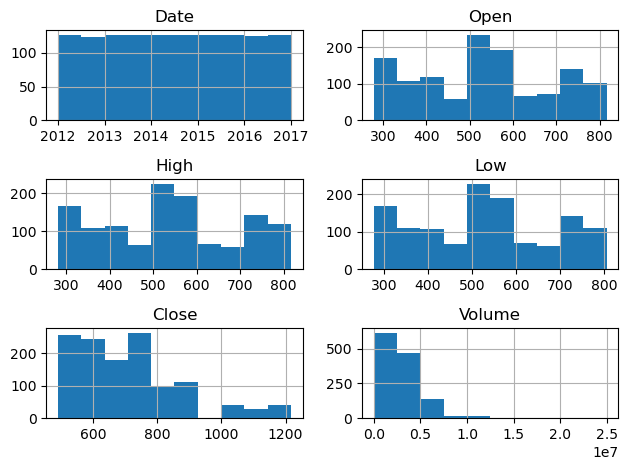

In [12]:
data.hist()
plt.tight_layout()
plt.show()

In [13]:
data[data['Volume'] > 15000000]

,Date,Open,High,Low,Close,Volume
12,2012-01-20,294.16,294.40,289.76,584.39,21231800
70,2012-04-13,322.57,323.28,310.61,622.89,16379700
201,2012-10-18,376.36,378.29,336.74,693.10,24977900
202,2012-10-19,351.47,352.03,334.75,679.92,23050400
451,2013-10-18,486.47,505.83,485.18,1008.64,23219400


In [14]:
data.loc[data['Volume'] > 15000000, 'Volume'] = np.NAN
data['Volume'].fillna(data['Volume'].median(), inplace=True)

In [15]:
data.sort_values(by='Date', inplace=True)
test_data.sort_values(by='Date', inplace=True)

In [16]:
data.head(10)

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0
5,2012-01-10,313.70,315.72,307.30,621.43,8824000.0
6,2012-01-11,310.59,313.52,309.40,624.25,4817800.0
7,2012-01-12,314.43,315.26,312.08,627.92,3764400.0
8,2012-01-13,311.96,312.30,309.37,623.28,4631800.0
9,2012-01-17,314.81,314.81,311.67,626.86,3832800.0


In [ ]:
def create_X_y(data, features, N=30, M=1):
    """
    Create input and output data.

    :param data: DataFrame containing time series data.
    :param features: List of features to use.
    :param N: The past N days as input.
    :param M: The future M days as output.
    :return: Input X and output y.
    """
    X, y = [], []
    feature_data = data[features].values
    for i in range(len(feature_data) - N - M + 1):
        X.append(feature_data[i:i + N])
        y.append(feature_data[i + N:i + N + M])
    
    return np.array(X), np.array(y)

In [18]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
N = 15
M = 3

X, y = create_X_y(data, features, N, M)

print("X shape:", X.shape)
print("y shape:", y.shape) 

X shape: (1241, 15, 5)
y shape: (1241, 3, 5)


In [19]:
X_test, y_test = create_X_y(test_data, features, N, M)
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)

X shape: (3, 15, 5)
y shape: (3, 3, 5)


In [ ]:
split_index = int(len(X) * 0.8)  # 80% training, 20% validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (992, 15, 5)
y_train shape: (992, 3, 5)
X_val shape: (249, 15, 5)
y_val shape: (249, 3, 5)


In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [22]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_val_scaled = y_scaler.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
y_test_scaled = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

### BaseLine

In [ ]:
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_val_flat = X_val_scaled.reshape(X_val_scaled.shape[0], -1)

y_train_flat = y_train_scaled.reshape(y_train_scaled.shape[0], -1)
y_val_flat = y_val_scaled.reshape(y_val_scaled.shape[0], -1)

In [ ]:
degree = 3  # Set the degree of the polynomial regression
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_flat)
X_val_poly = poly.transform(X_val_flat)
alpha = 10.0  # Regularization strength
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_poly, y_train_flat)

Ridge(alpha=10.0)

In [27]:
y_train_pred = ridge_model.predict(X_train_poly)
y_val_pred = ridge_model.predict(X_val_poly)

train_mse = mean_squared_error(y_train_flat, y_train_pred)
val_mse = mean_squared_error(y_val_flat, y_val_pred)

print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")

Train MSE: 0.0062
Validation MSE: 0.9621


### RNN

In [ ]:
# Convert to tensor
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_scaled, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, M=3):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.M = M

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, M * output_size)  # Predict M days ahead, with output_size features

    def forward(self, x):
        out, _ = self.rnn(x)
        
        # Take the output of the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        out = self.fc(out)    # (batch_size, M * output_size)
        
        # Reshape the output to (batch_size, M, output_size) for predicting the next M days
        out = out.view(-1, self.M, self.output_size)
        return out

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=20, patience=5, gamma=0.9):
    criterion = nn.MSELoss()  # Use mean squared error loss function

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    train_losses = []
    val_losses = []

    # Early stopping parameters
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.float(), targets.float()
            optimizer.zero_grad()  # Clear gradients

            # Forward propagation
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

        # Schedule the learning rate
        scheduler.step()

        # Record the current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Calculate the average loss on the training set
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()  # Set to evaluation mode
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.float(), targets.float()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()

        # Calculate the average loss on the validation set
        val_losses.append(epoch_val_loss / len(val_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, LR: {current_lr:.6f}')

        # Early stopping mechanism
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs. Best Validation Loss: {best_val_loss:.4f}')
            break

    return train_losses, val_losses

In [43]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def objective(trial):
    # Hyperparameter search space
    hidden_size = trial.suggest_int("hidden_size", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    # Fixed parameters
    input_size = X_train_scaled.shape[-1]
    output_size = y_train_scaled.shape[-1]
    M = 3

    model = StockRNN(input_size, hidden_size, output_size, num_layers, M).to(device)

    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    with HiddenPrints():
        train_losses, val_losses = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            num_epochs=20,
        )
    
    return val_losses[-1]

# Create Optuna study object and optimize
study = optuna.create_study(direction="minimize")  # The smaller the loss, the better
study.optimize(objective, n_trials=200)  # Conduct 200 experiments

[I 2024-11-24 20:39:15,239] A new study created in memory with name: no-name-2618635c-7a39-4bed-bbf6-2e84da335eb6
[I 2024-11-24 20:39:16,259] Trial 0 finished with value: 0.9042972922325134 and parameters: {'hidden_size': 112, 'lr': 0.001935899574156, 'optimizer': 'RMSprop', 'num_layers': 3}. Best is trial 0 with value: 0.9042972922325134.
[I 2024-11-24 20:39:17,555] Trial 1 finished with value: 0.35780419409275055 and parameters: {'hidden_size': 48, 'lr': 0.034666130088638926, 'optimizer': 'SGD', 'num_layers': 2}. Best is trial 1 with value: 0.35780419409275055.
[I 2024-11-24 20:39:18,869] Trial 2 finished with value: 0.1092008575797081 and parameters: {'hidden_size': 48, 'lr': 0.000963321524955459, 'optimizer': 'RMSprop', 'num_layers': 2}. Best is trial 2 with value: 0.1092008575797081.
[I 2024-11-24 20:39:19,486] Trial 3 finished with value: 0.5602198466658592 and parameters: {'hidden_size': 32, 'lr': 0.03282784064813751, 'optimizer': 'Adam', 'num_layers': 3}. Best is trial 2 with v

In [29]:
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

Best trial:
  Value: 0.04366696299985051
  Params: {'hidden_size': 96, 'lr': 0.002365365347535439, 'optimizer': 'RMSprop', 'num_layers': 1}


In [ ]:
input_size = X_train_scaled.shape[-1]
hidden_size = 96
output_size = y_train_scaled.shape[-1]
num_layers = 1
model = StockRNN(input_size, hidden_size, output_size, num_layers).to(device)
learning_rate = 0.0023
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 0.8559, Validation Loss: 0.2596, LR: 0.002070
Epoch [2/30], Train Loss: 0.5783, Validation Loss: 0.1434, LR: 0.001863
Epoch [3/30], Train Loss: 0.3744, Validation Loss: 0.1011, LR: 0.001677
Epoch [4/30], Train Loss: 0.2461, Validation Loss: 0.0851, LR: 0.001509
Epoch [5/30], Train Loss: 0.1752, Validation Loss: 0.1297, LR: 0.001358
Epoch [6/30], Train Loss: 0.1770, Validation Loss: 0.1036, LR: 0.001222
Epoch [7/30], Train Loss: 0.1550, Validation Loss: 0.0650, LR: 0.001100
Epoch [8/30], Train Loss: 0.1404, Validation Loss: 0.0607, LR: 0.000990
Epoch [9/30], Train Loss: 0.1343, Validation Loss: 0.0580, LR: 0.000891
Epoch [10/30], Train Loss: 0.1284, Validation Loss: 0.0564, LR: 0.000802
Epoch [11/30], Train Loss: 0.1251, Validation Loss: 0.0553, LR: 0.000722
Epoch [12/30], Train Loss: 0.1229, Validation Loss: 0.0547, LR: 0.000650
Epoch [13/30], Train Loss: 0.1213, Validation Loss: 0.0545, LR: 0.000585
Epoch [14/30], Train Loss: 0.1201, Validation Loss: 0.0544, 

In [ ]:
def plot_learning_curves(train_losses, val_losses, title='Learning Curves', xlabel='Epoch', ylabel='MSE Loss'):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

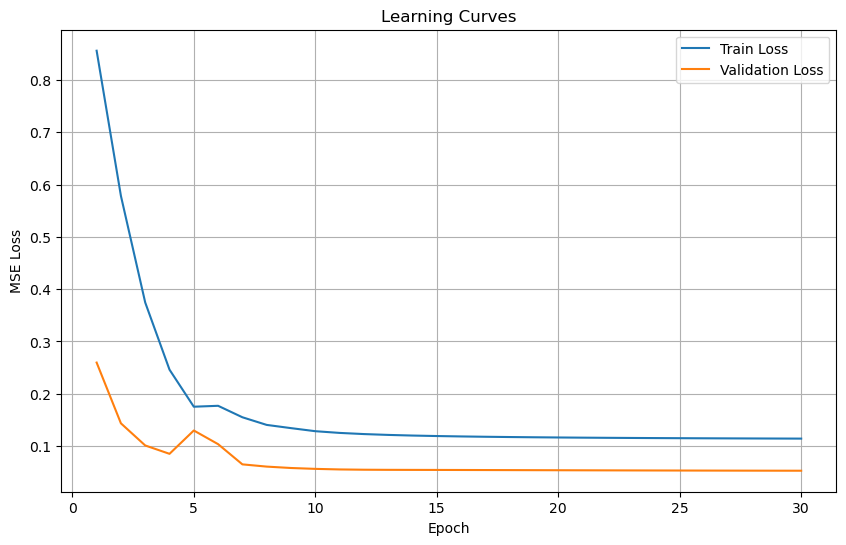

In [29]:
plot_learning_curves(train_losses, val_losses)

### GRU

In [ ]:
class StockGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, M=3):
        super(StockGRU, self).__init__()
        self.M = M
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, M * output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)  # (batch_size, M * output_size)
        
        # Reshape the output dimension to (batch_size, M, output_size)
        out = out.view(-1, self.M, self.output_size)  # (batch_size, M, output_size)
        return out

In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    input_size = X_train_scaled.shape[-1]
    output_size = y_train_scaled.shape[-1]
    M = 3

    model = StockGRU(input_size, hidden_size, output_size, num_layers, M).to(device)

    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    with HiddenPrints():
        train_losses, val_losses = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            num_epochs=20,
        )
    
    return val_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

[I 2024-11-24 21:15:10,308] A new study created in memory with name: no-name-e8a7d0ce-7f9f-4c5d-9dbf-9fcb7dbd1385
[I 2024-11-24 21:15:14,799] Trial 0 finished with value: 0.33915289491415024 and parameters: {'hidden_size': 64, 'lr': 0.04127095411256736, 'optimizer': 'SGD', 'num_layers': 3}. Best is trial 0 with value: 0.33915289491415024.
[I 2024-11-24 21:15:19,743] Trial 1 finished with value: 0.045404800213873386 and parameters: {'hidden_size': 128, 'lr': 0.002743124697895883, 'optimizer': 'RMSprop', 'num_layers': 2}. Best is trial 1 with value: 0.045404800213873386.
[I 2024-11-24 21:15:22,420] Trial 2 finished with value: 0.08101494237780571 and parameters: {'hidden_size': 128, 'lr': 0.023243077345762916, 'optimizer': 'Adam', 'num_layers': 1}. Best is trial 1 with value: 0.045404800213873386.
[I 2024-11-24 21:15:23,532] Trial 3 finished with value: 2.5627386271953583 and parameters: {'hidden_size': 80, 'lr': 0.04886770943649829, 'optimizer': 'Adam', 'num_layers': 2}. Best is trial 1

In [47]:
print("Best trial for GRU:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

Best trial for GRU:
  Value: 0.04187859361991286
  Params: {'hidden_size': 80, 'lr': 0.004960404208340347, 'optimizer': 'RMSprop', 'num_layers': 1}


In [ ]:
input_size = X_train_scaled.shape[-1]
hidden_size = 80
output_size = y_train_scaled.shape[-1]
num_layers = 1
gru_model = StockGRU(input_size, hidden_size, output_size, num_layers).to(device)
learning_rate = 0.005
optimizer = torch.optim.RMSprop(gru_model.parameters(), lr=learning_rate)

gru_train_losses, gru_val_losses = train_model(gru_model, train_loader, val_loader, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 0.7870, Validation Loss: 0.6249, LR: 0.004500
Epoch [2/30], Train Loss: 0.2731, Validation Loss: 0.1723, LR: 0.004050
Epoch [3/30], Train Loss: 0.1579, Validation Loss: 0.0916, LR: 0.003645
Epoch [4/30], Train Loss: 0.1286, Validation Loss: 0.0742, LR: 0.003281
Epoch [5/30], Train Loss: 0.1235, Validation Loss: 0.0702, LR: 0.002952
Epoch [6/30], Train Loss: 0.1227, Validation Loss: 0.0669, LR: 0.002657
Epoch [7/30], Train Loss: 0.1204, Validation Loss: 0.0595, LR: 0.002391
Epoch [8/30], Train Loss: 0.1185, Validation Loss: 0.0524, LR: 0.002152
Epoch [9/30], Train Loss: 0.1169, Validation Loss: 0.0474, LR: 0.001937
Epoch [10/30], Train Loss: 0.1157, Validation Loss: 0.0446, LR: 0.001743
Epoch [11/30], Train Loss: 0.1147, Validation Loss: 0.0433, LR: 0.001569
Epoch [12/30], Train Loss: 0.1141, Validation Loss: 0.0428, LR: 0.001412
Epoch [13/30], Train Loss: 0.1136, Validation Loss: 0.0427, LR: 0.001271
Epoch [14/30], Train Loss: 0.1132, Validation Loss: 0.0427, 

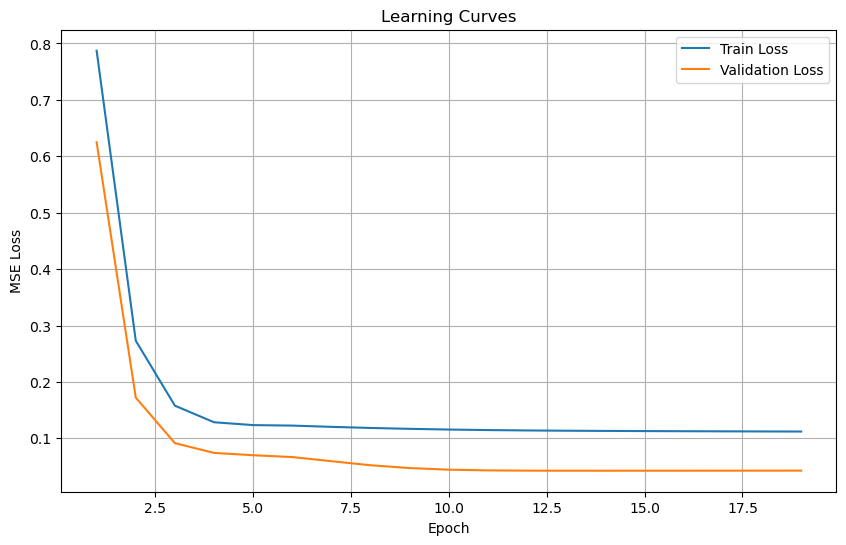

In [51]:
plot_learning_curves(gru_train_losses, gru_val_losses)

### LSTM

In [ ]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, m):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.m = m
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * m)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, seq_length, hidden_size]
        out = out[:, -1, :]  # [batch_size, hidden_size]
        out = self.fc(out)  # [batch_size, output_size * m]
        out = out.view(-1, self.m, output_size)
        return out

In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    
    input_size = X_train_scaled.shape[-1]
    output_size = y_train_scaled.shape[-1]
    M = 3

    model = StockLSTM(input_size, hidden_size, output_size, num_layers, M).to(device)

    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    with HiddenPrints():
        train_losses, val_losses = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            num_epochs=20,
        )
    
    return val_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=170)

[I 2024-11-24 20:55:37,574] A new study created in memory with name: no-name-f225a51a-2b24-407d-872a-14bfdcb76523
[I 2024-11-24 20:55:39,243] Trial 0 finished with value: 2.8737544417381287 and parameters: {'hidden_size': 80, 'lr': 0.009530933614654586, 'optimizer': 'SGD', 'num_layers': 2}. Best is trial 0 with value: 2.8737544417381287.
[I 2024-11-24 20:55:40,091] Trial 1 finished with value: 2.9030961394309998 and parameters: {'hidden_size': 64, 'lr': 0.0033391301247123546, 'optimizer': 'SGD', 'num_layers': 1}. Best is trial 0 with value: 2.8737544417381287.
[I 2024-11-24 20:55:41,918] Trial 2 finished with value: 1.2454271763563156 and parameters: {'hidden_size': 80, 'lr': 0.0001927138339457442, 'optimizer': 'Adam', 'num_layers': 2}. Best is trial 2 with value: 1.2454271763563156.
[I 2024-11-24 20:55:43,451] Trial 3 finished with value: 2.844283699989319 and parameters: {'hidden_size': 32, 'lr': 0.05904023055656948, 'optimizer': 'SGD', 'num_layers': 3}. Best is trial 2 with value: 1

In [42]:
print("Best trial for LSTM:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

Best trial for LSTM:
  Value: 0.0431833048351109
  Params: {'hidden_size': 112, 'lr': 0.012426783099892645, 'optimizer': 'RMSprop', 'num_layers': 1}


In [ ]:
input_size = X_train_scaled.shape[-1]
hidden_size = 112
output_size = y_train_scaled.shape[-1]
num_layers = 1
m = 3
learning_rate = 0.012
lstm_model = StockLSTM(input_size, hidden_size, output_size, num_layers, m).to(device)
optimizer = torch.optim.RMSprop(lstm_model.parameters(), lr=learning_rate)

lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 4.8752, Validation Loss: 0.4879, LR: 0.010800
Epoch [2/30], Train Loss: 0.6625, Validation Loss: 0.1480, LR: 0.009720
Epoch [3/30], Train Loss: 0.3236, Validation Loss: 0.0902, LR: 0.008748
Epoch [4/30], Train Loss: 0.1762, Validation Loss: 0.1741, LR: 0.007873
Epoch [5/30], Train Loss: 0.1634, Validation Loss: 0.0891, LR: 0.007086
Epoch [6/30], Train Loss: 0.1366, Validation Loss: 0.0773, LR: 0.006377
Epoch [7/30], Train Loss: 0.1319, Validation Loss: 0.0855, LR: 0.005740
Epoch [8/30], Train Loss: 0.1278, Validation Loss: 0.0717, LR: 0.005166
Epoch [9/30], Train Loss: 0.1255, Validation Loss: 0.0681, LR: 0.004649
Epoch [10/30], Train Loss: 0.1238, Validation Loss: 0.0944, LR: 0.004184
Epoch [11/30], Train Loss: 0.1216, Validation Loss: 0.0555, LR: 0.003766
Epoch [12/30], Train Loss: 0.1193, Validation Loss: 0.0490, LR: 0.003389
Epoch [13/30], Train Loss: 0.1184, Validation Loss: 0.0530, LR: 0.003050
Epoch [14/30], Train Loss: 0.1181, Validation Loss: 0.0507, 

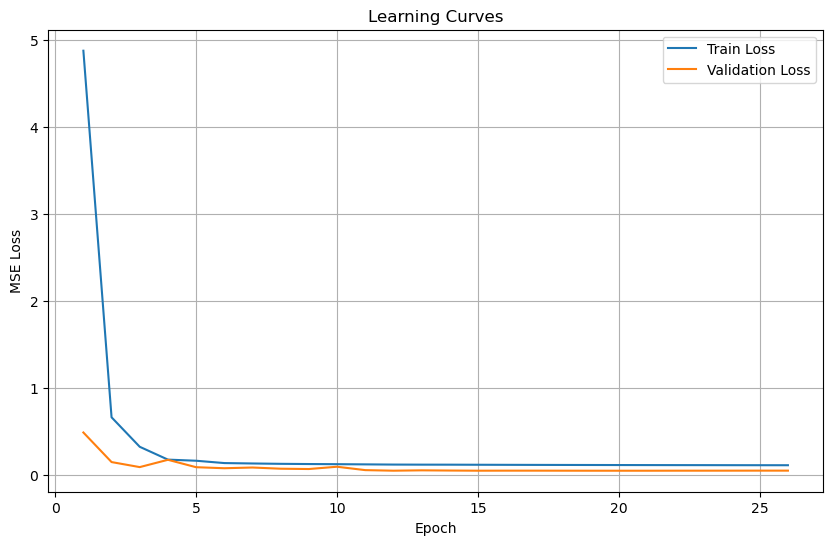

In [33]:
plot_learning_curves(lstm_train_losses, lstm_val_losses)

### Test set

In [ ]:
gru_model.eval()
y_test_pred = []
y_test_true = []

# No need to compute gradients
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.float(), targets.float()

        # Prediction
        outputs = gru_model(inputs)

        # Store the true values and predictions
        y_test_true.append(targets.numpy())
        y_test_pred.append(outputs.numpy())

# Convert to numpy array
y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)

In [53]:
y_test_true_flat = y_test_true.reshape(-1, y_test_true.shape[0])
y_test_pred_flat = y_test_pred.reshape(-1, y_test_pred.shape[0])
test_mse = mean_squared_error(y_test_true_flat, y_test_pred_flat)
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 0.0812
